In [1]:
import PIL
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstatsπ
from tqdm.notebook import tqdm

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

# Resampling: Inverse transform

In [2]:
if "dr7_quasar.npy" not in "/Users/olga/astroML_data":
    from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

n=len(z)

In [3]:
import astropy
astropy.cosmology.Planck15

FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

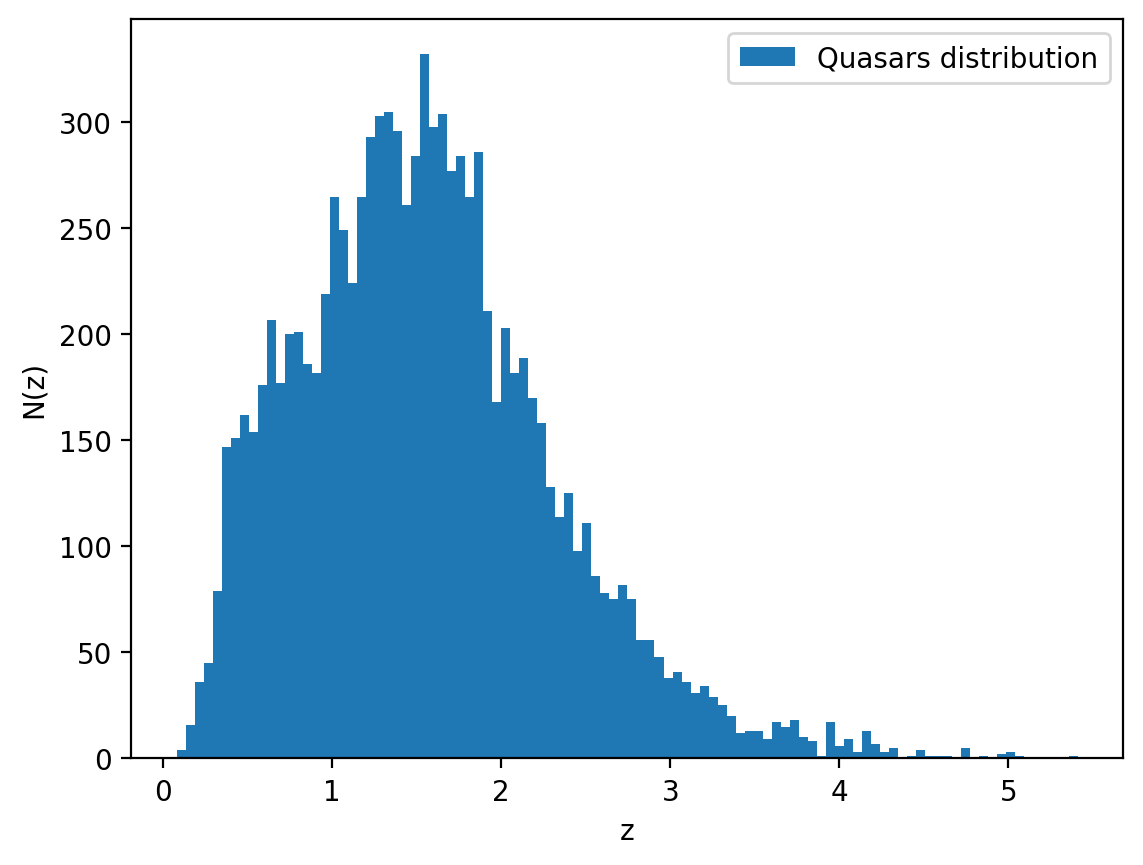

In [4]:
counts_z, bins_z, bars_z = plt.hist(z,bins=100, label="Quasars distribution")
plt.xlabel('z')
plt.ylabel('N(z)')
plt.legend()
plt.show()

## Let's try as in book

Clone distribution with $\texttt{EmpiricalDistribution}$ from $\texttt{astroML.density_estimation}$ (fig 3.25. - "Statistics, Data Mining, and Machine Learning in Astronomy" (2013), Author: Jake VanderPlas)

Basically what the algorithm does is finding the cumulative, invert and fit it with an "efficient cubic spline" (book and documentation). Then $\texttt{.rvs}$ draws random variables from the empirical distribution found this way.\
Let's show how it works:

In [5]:
counts_cloned = EmpiricalDistribution(z).rvs(n)

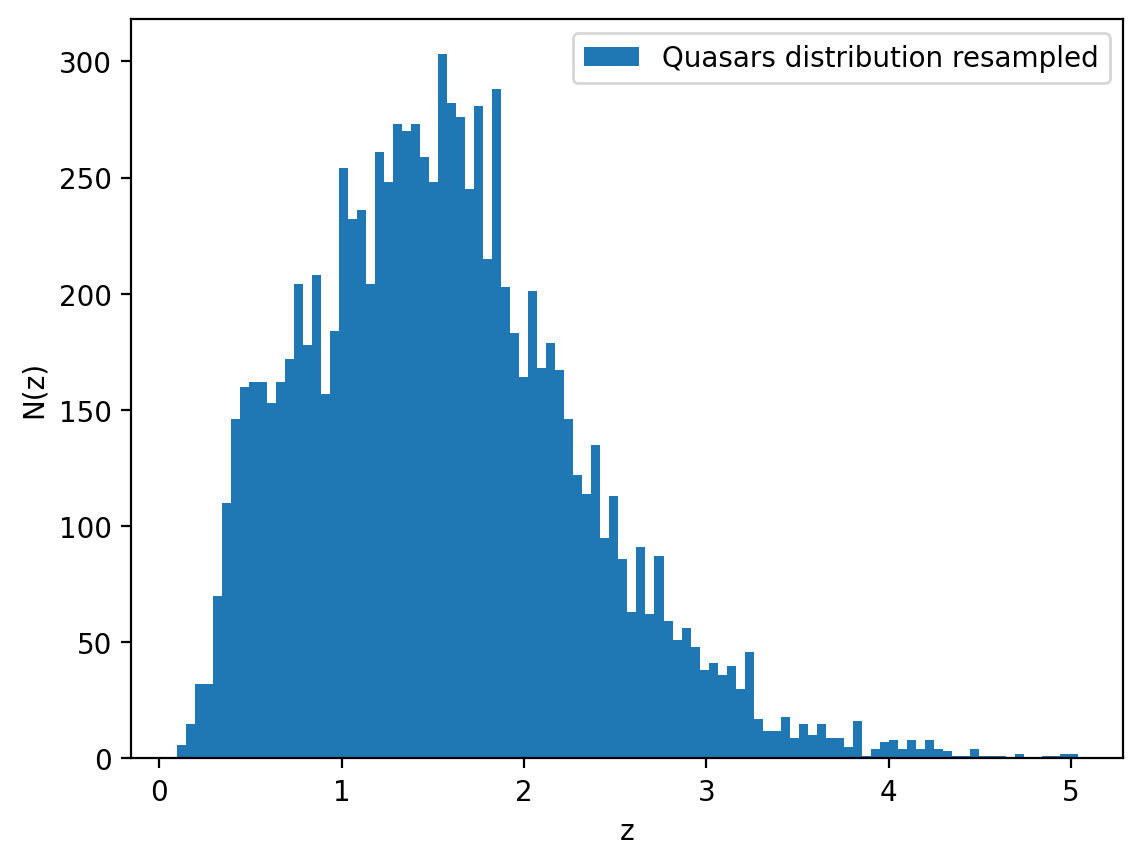

In [6]:
c_cloned, bins_cloned, bars_cloned = plt.hist(counts_cloned,bins=100, label="Quasars distribution resampled")
plt.xlabel('z')
plt.ylabel('N(z)')
plt.legend()
plt.show()

In [7]:
# compute the KS test to check if they're the same (only applies if dimension of the two distrib is the same)
D, p = stats.ks_2samp(z, counts_cloned)
print("KS test: D = %.2g; p = %.2g" % (D, p))

KS test: D = 0.011; p = 0.63


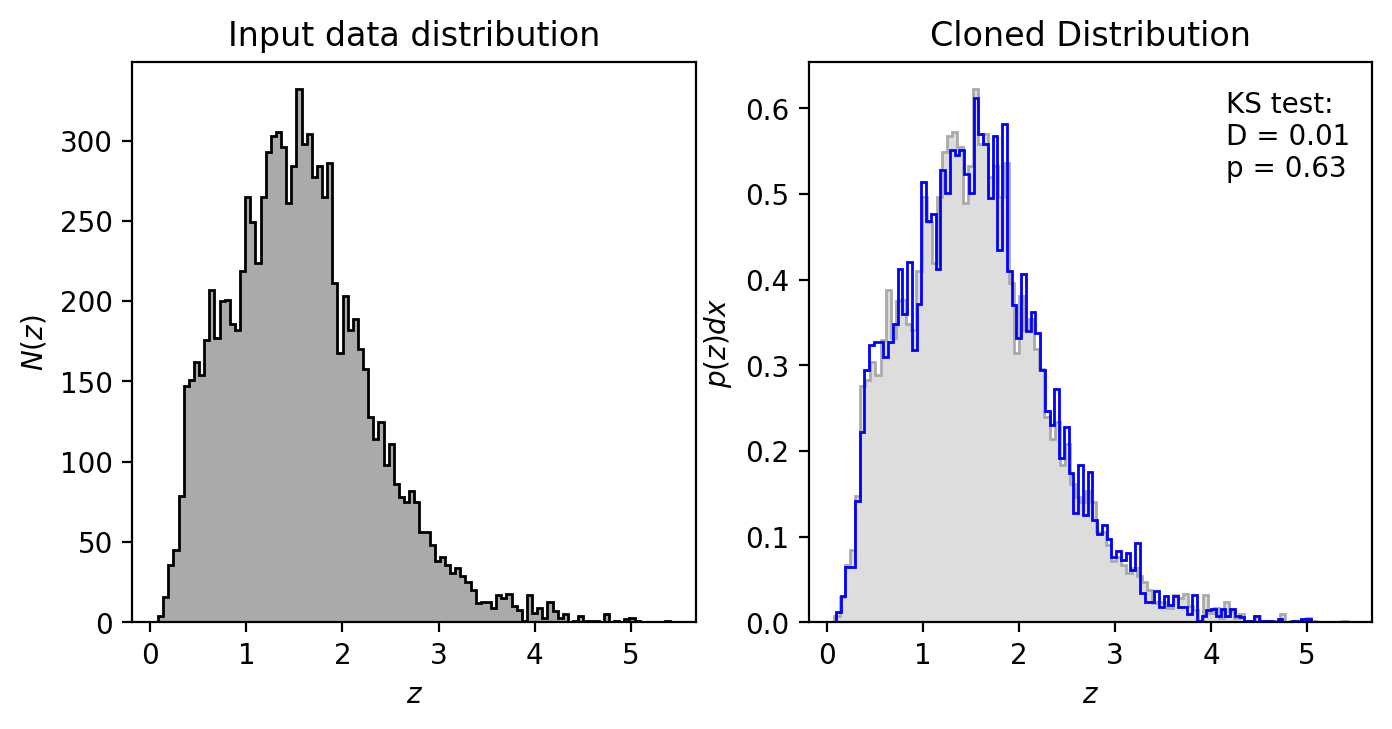

In [8]:
fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
#ax.set_ylim(0, 350)
ax.set_title('Input data distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')

ax = fig.add_subplot(222)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(counts_cloned, bins=100, ax=ax,
     histtype='step', density=True,
     color='b', label='cloned data')
ax.set_title('Cloned Distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$p(z)dx$')
ax.text(0.74, 0.95, "KS test:\nD = %.2f\np = %.2f" % (D, p),
        ha='left', va='top', transform=ax.transAxes)

plt.show()

## Let's try step by step inverting the cumulative

&#10148; When resampling the cumulative, generate y from 0 to 1 with fixed step

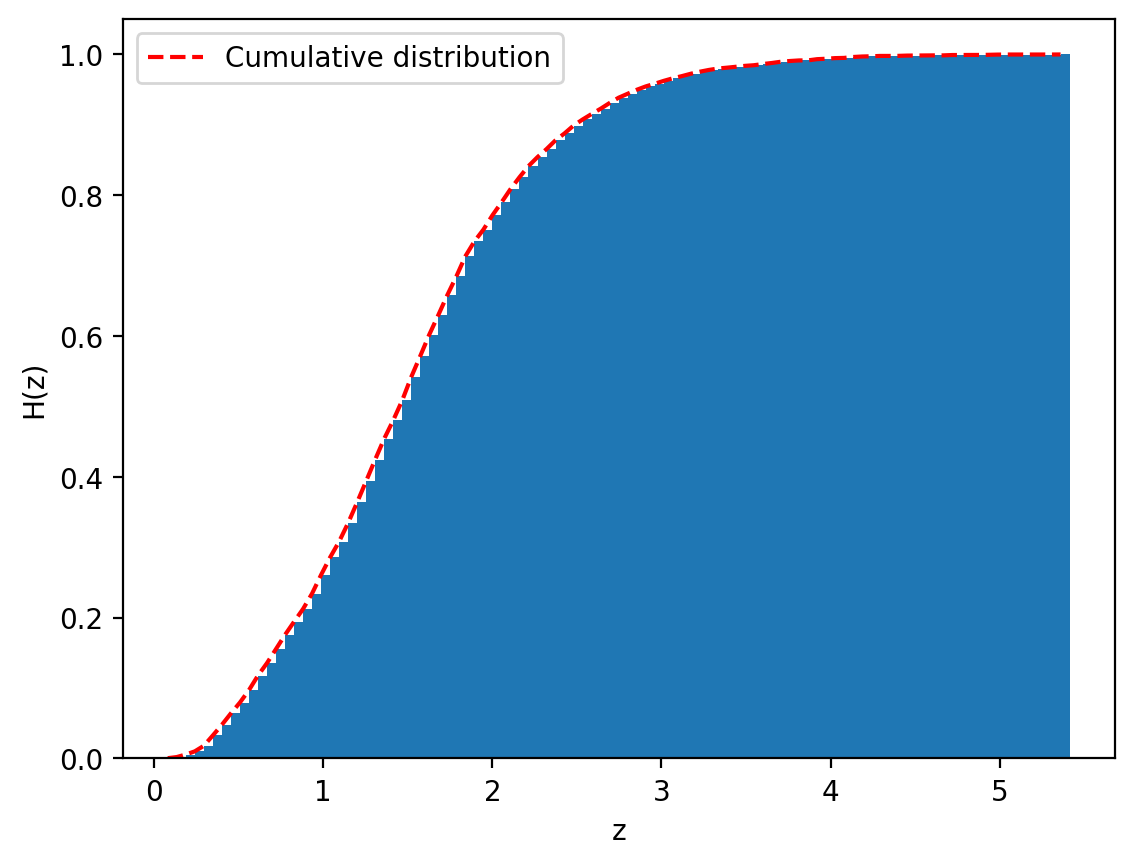

In [9]:
counts, bins, bars = plt.hist(z,bins=100,density=True,cumulative=True)
plt.plot(bins[:-1],counts,color='red', linestyle="dashed", label="Cumulative distribution")
plt.xlabel('z')
plt.ylabel('H(z)')
plt.legend()
plt.show()

In [10]:
x = np.arange(0,1,step=0.0001)
len(x)
len(bins)

new_y = np.interp(x, counts, bins[:-1])
len(new_y)

10000

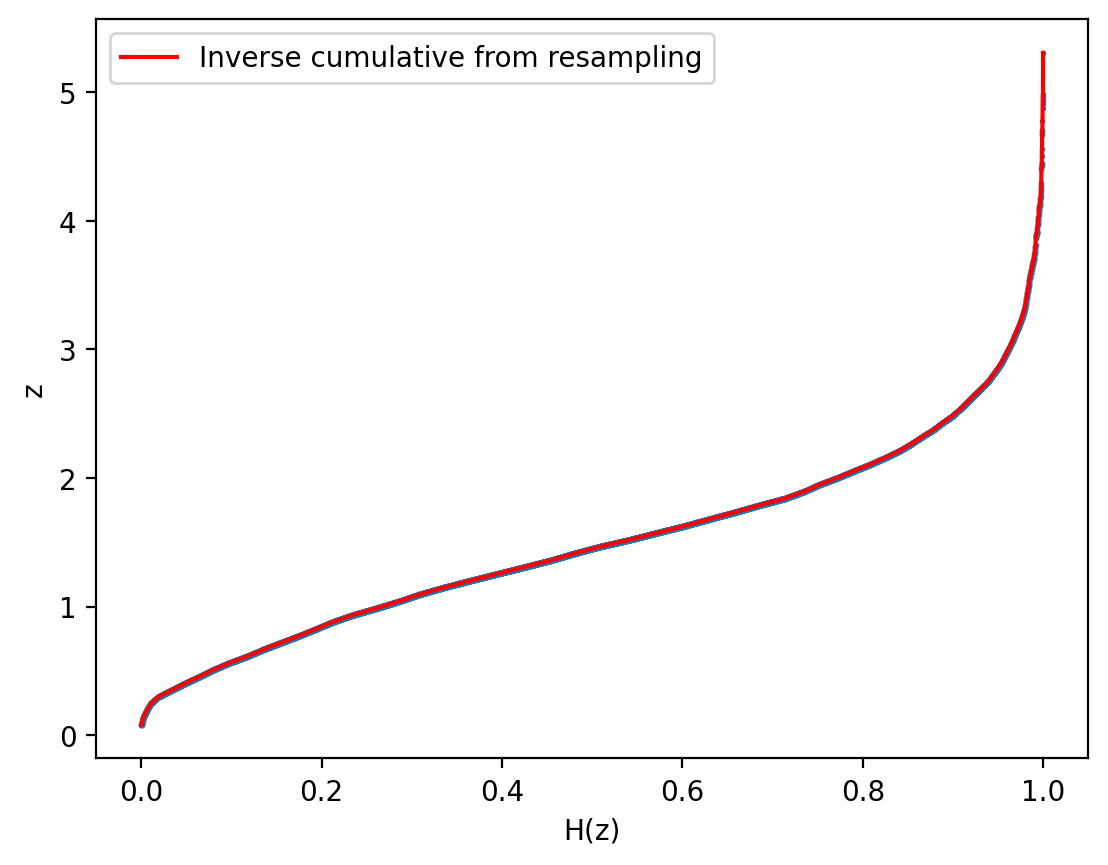

In [11]:
plt.scatter(x, new_y, s=1)
plt.plot(x, new_y, 'red', label="Inverse cumulative from resampling")
plt.ylabel('z')
plt.xlabel('H(z)')
plt.legend()
plt.show()

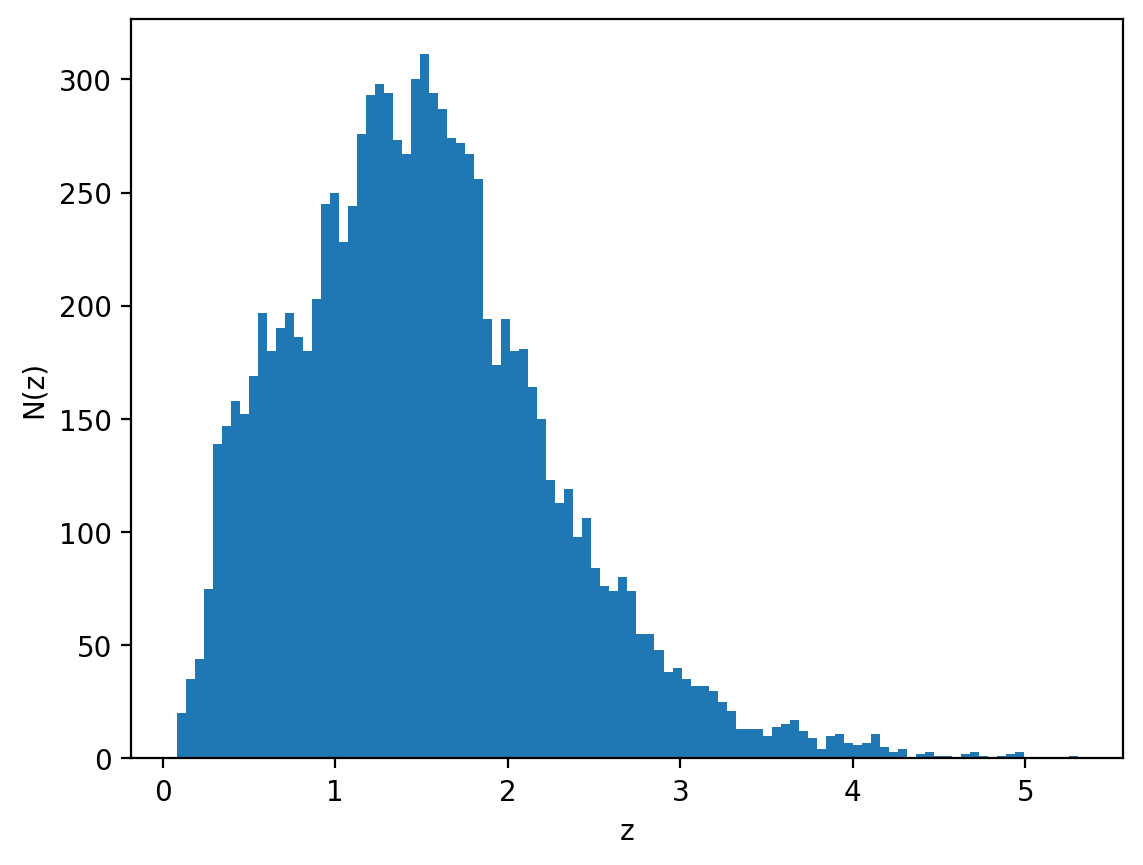

In [12]:
plt.hist(new_y, bins=100)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

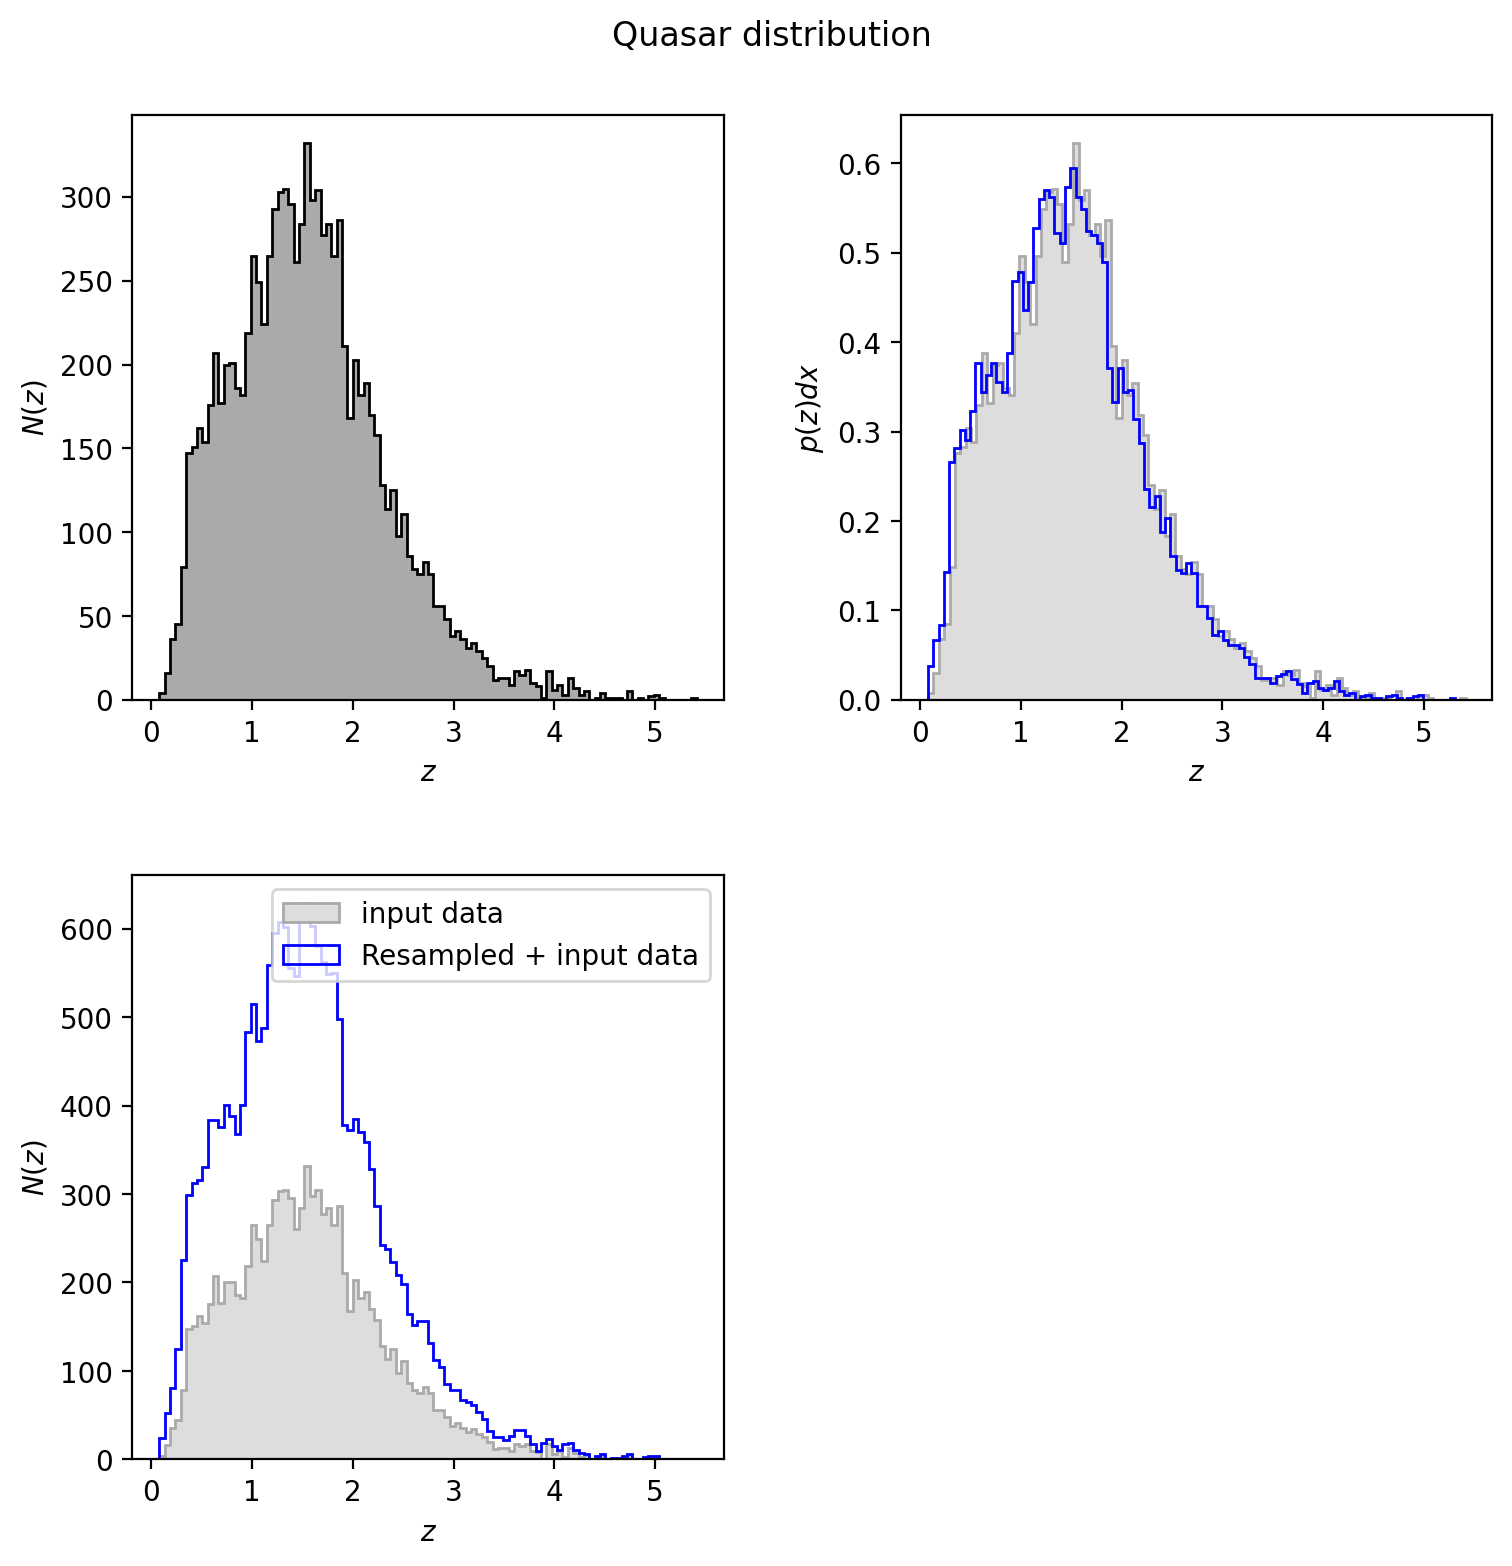

In [13]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)
fig.suptitle('Quasar distribution')

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
#ax.set_ylim(0, 350)
#ax.set_title('Input data distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')

ax = fig.add_subplot(222)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(new_y, bins=100, ax=ax,
     histtype='step', density=True,
     color='b', label='Resampled data')
#ax.set_title('Cloned Distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$p(z)dx$')

ax = fig.add_subplot(223)
hist(z, bins=100, ax=ax,
     histtype='stepfilled',
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(np.concatenate((z,new_y)), bins=100, ax=ax,
     histtype='step',
     color='b', label='Resampled + input data')
#ax.set_title('Cloned Distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')
plt.legend(loc='upper right')
plt.show()

&#10148; When resampling, generate y with rand uniform

In [14]:
rand_x = np.random.uniform(0,1,10000)
rand_x.sort()
rand_y = np.interp(rand_x, counts, bins[:-1])

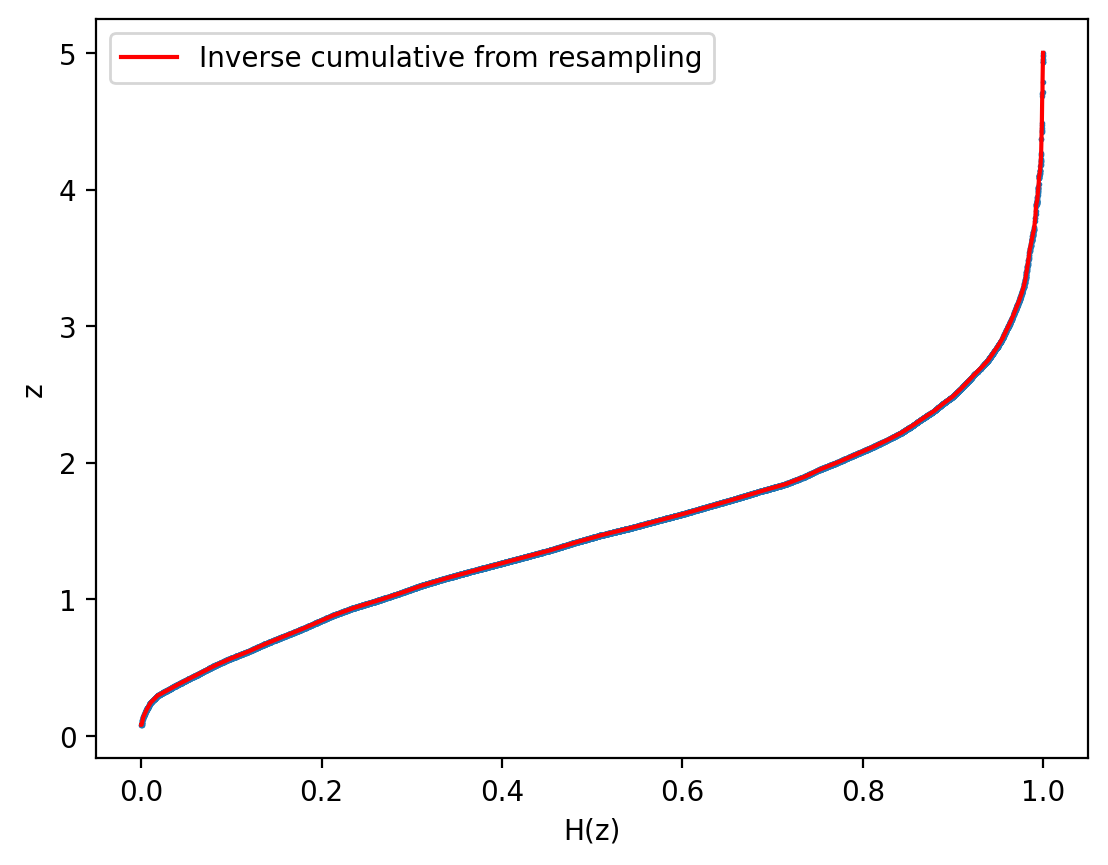

In [15]:
plt.scatter(rand_x, rand_y, s=1)
plt.plot(rand_x, rand_y, 'red', label="Inverse cumulative from resampling")
plt.ylabel('z')
plt.xlabel('H(z)')
plt.legend()
plt.show()

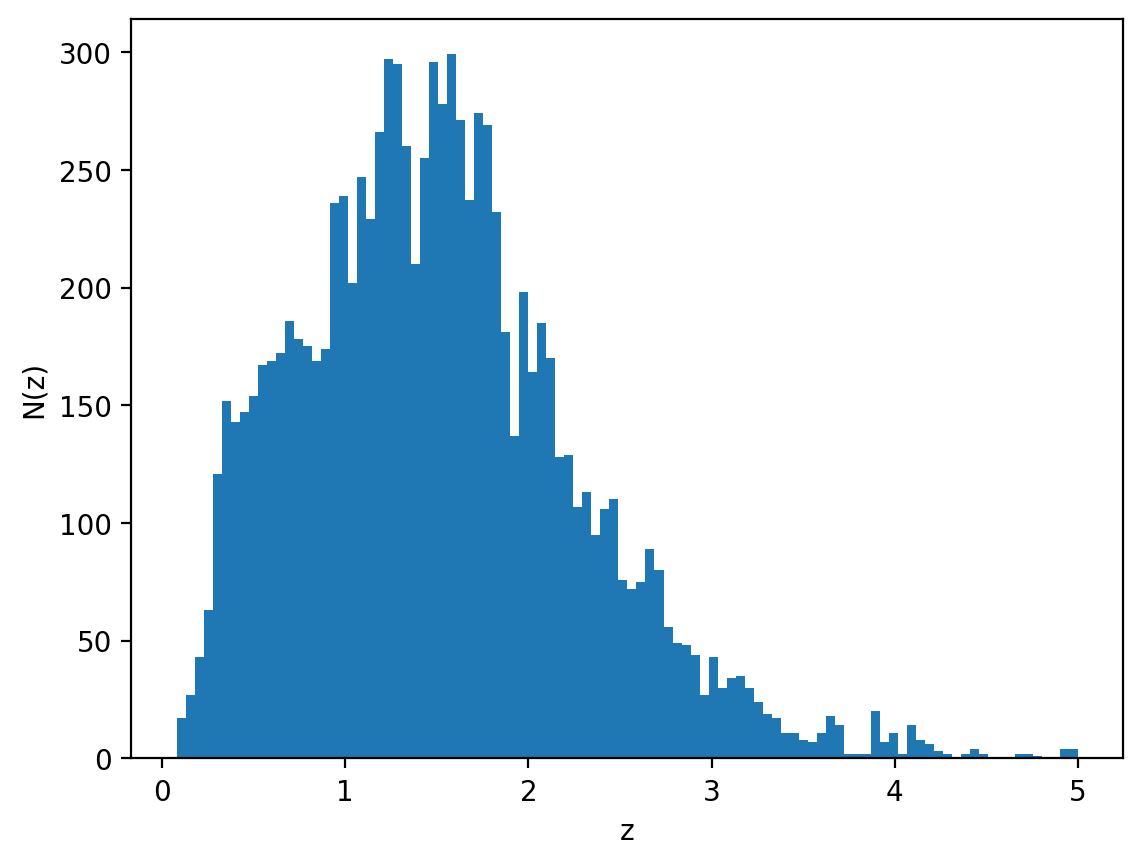

In [16]:
plt.hist(rand_y, bins=100)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

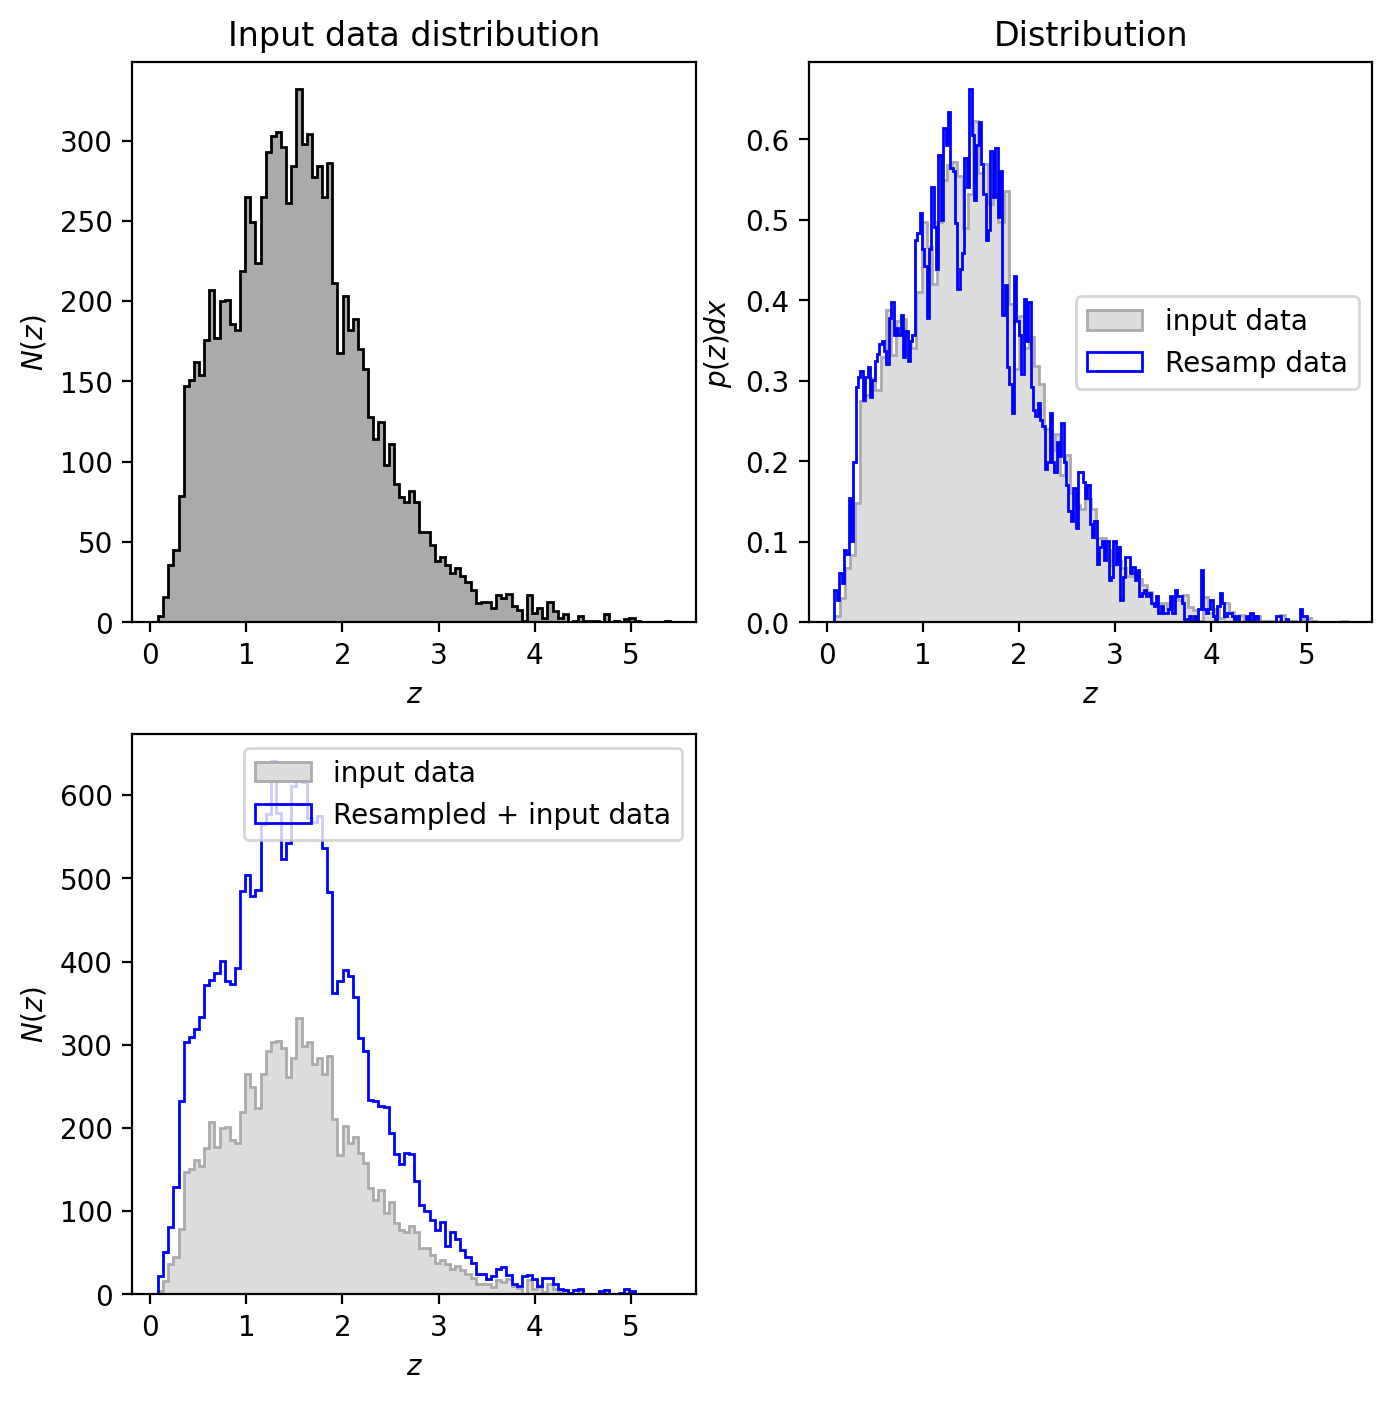

In [17]:
fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
#ax.set_ylim(0, 350)
ax.set_title('Input data distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')

ax = fig.add_subplot(222)
hist(z, bins=100, ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(rand_y, bins=200, ax=ax,
     histtype='step', density=True,
     color='b', label='Resamp data')
ax.set_title('Distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$p(z)dx$')
plt.legend(loc='center right')

ax = fig.add_subplot(223)
hist(z, bins=100, ax=ax,
     histtype='stepfilled',
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(np.concatenate((z,rand_y)), bins=100, ax=ax,
     histtype='step',
     color='b', label='Resampled + input data')
#ax.set_title('Cloned Distribution')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')
plt.legend(loc='upper right')

plt.show()

# Rejection sampling

&#10148; Generate some random points\
&#10148; Accept only the ones below the distribution function (known or unknown)\
&#10148; The $x_s$ obtained this way are your re-sampled data with the given distribution

## With known distribution function (almost never)

In [18]:
def f(x) :
    #return np.abs(np.sin(6*x))
    return x + np.sin(4*x)

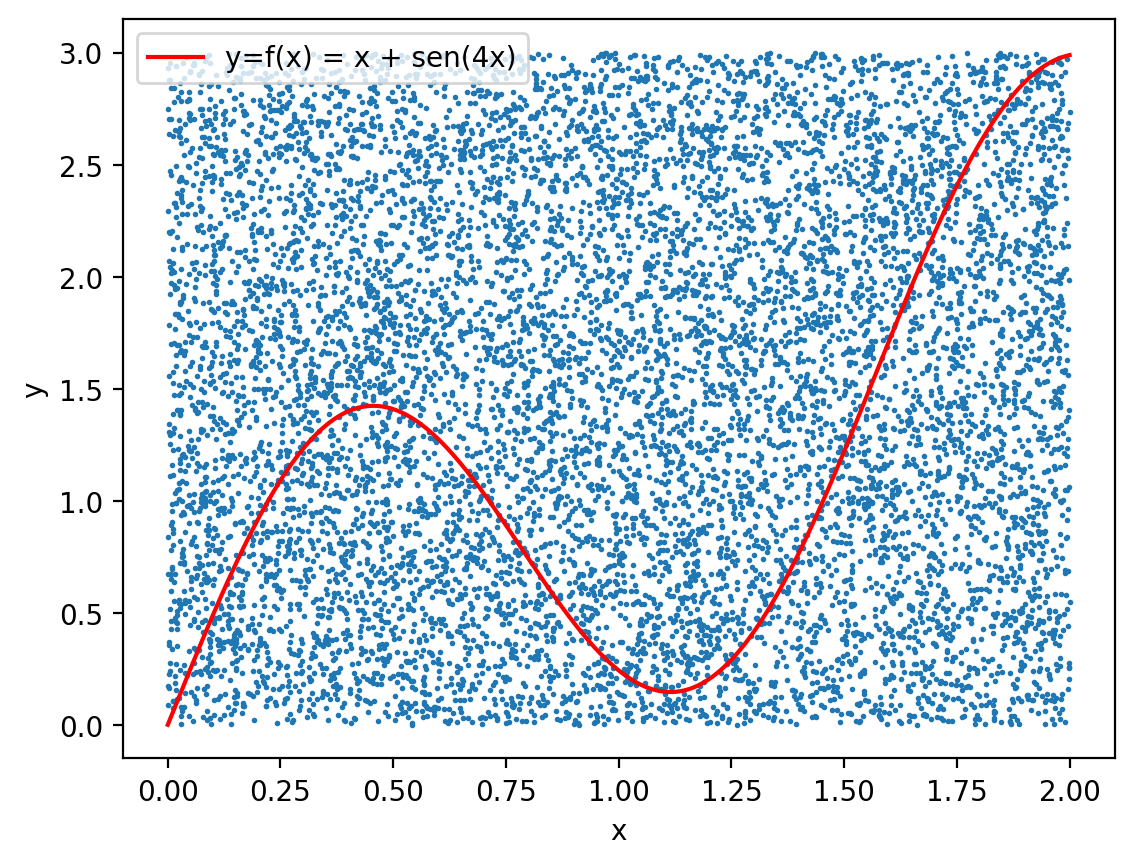

In [19]:
x = np.random.uniform(0,2,10000)
y = np.random.uniform(0,3,10000)
x.sort()
fun = f(x)

plt.plot(x,fun, 'red', label='y=f(x) = x + sen(4x)')
plt.scatter(x,y, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

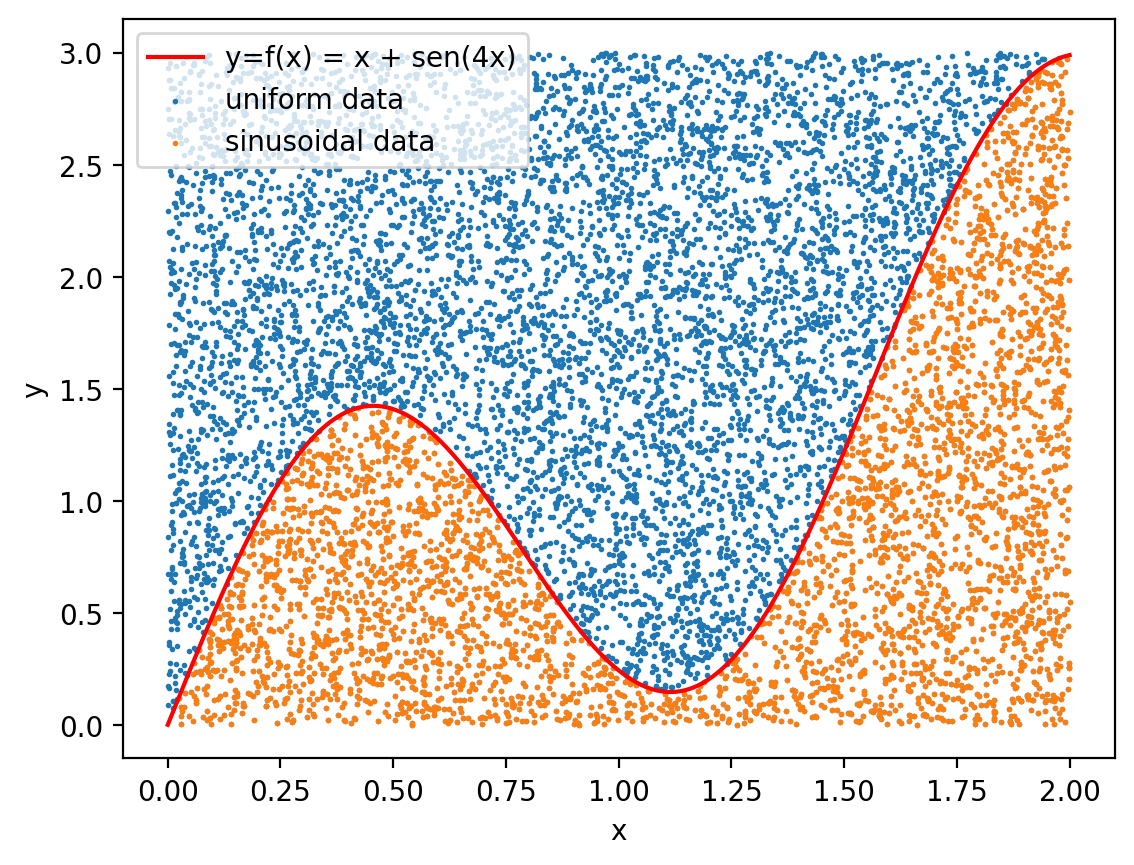

In [20]:
x_new = x[y < fun]
y_new = y[y < fun]

plt.plot(x,fun, 'red', label='y=f(x) = x + sen(4x)')
plt.scatter(x,y, s=1, label='uniform data')
plt.scatter(x_new, y_new, s=1, label='sinusoidal data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

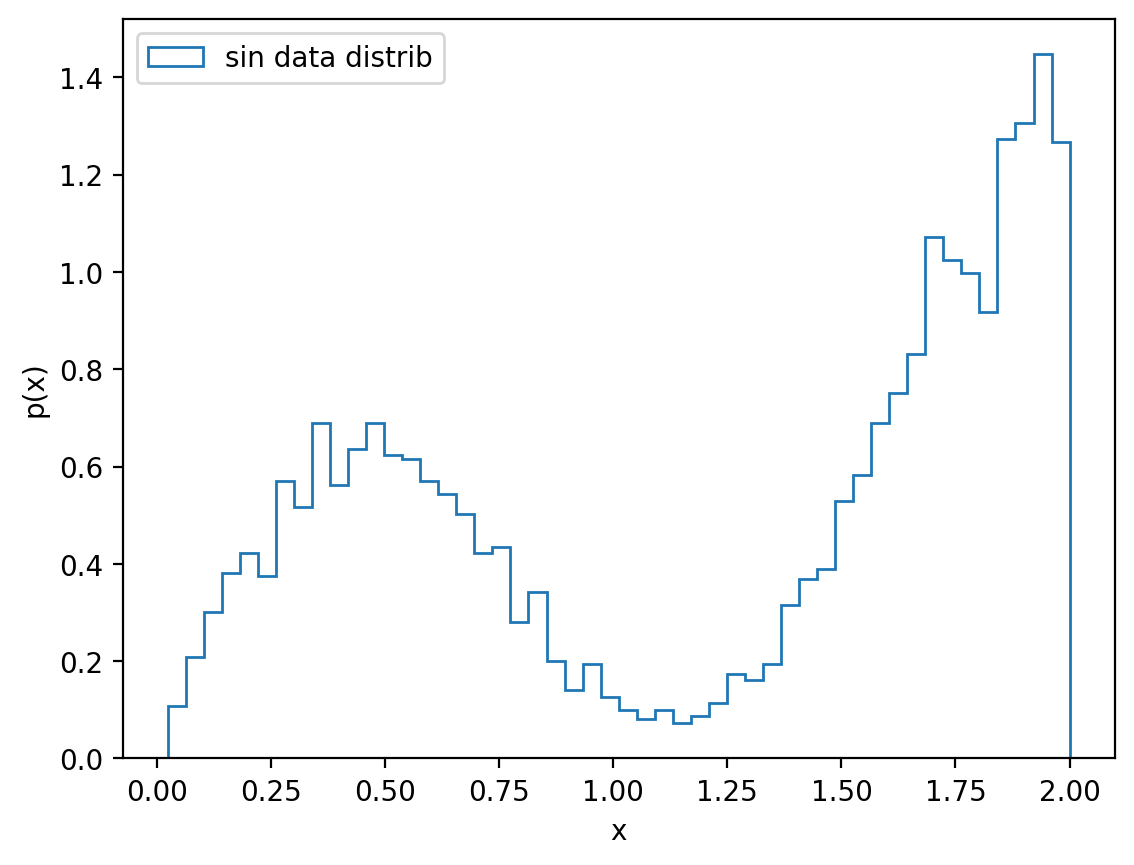

In [21]:
plt.hist(x_new, bins=50, density=True, histtype='step', label='sin data distrib')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

## Try again but with quasars data $\rightarrow$ unknown distribution!

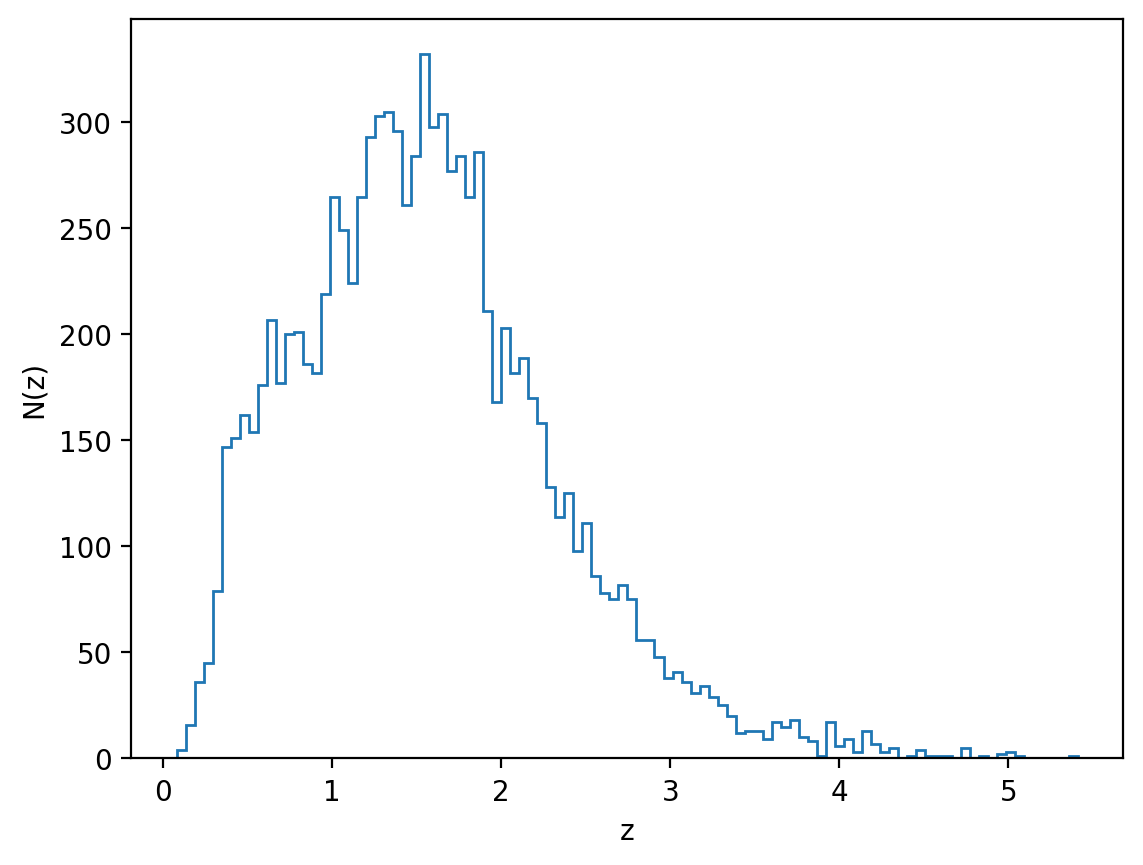

In [22]:
counts, bins, a = plt.hist(z,bins=100,histtype='step', zorder=1)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

In [23]:
#approssimative one (works well only for very high number of bins)
def emp_f(x):
    return np.interp(x, (bins_z[:-1]+bins_z[1:])/2, counts_z)

#precise one!
def step_f(x, bins, counts):
    
    a = min(bins)
    b = max(bins)
    bin_width = (b - a)/len(bins)
    xgrid = np.linspace(min(bins), max(bins),300)
    step = np.zeros(len(xgrid))
    lenght1 = np.zeros(len(bins))
    lenght = np.zeros(len(bins)).astype(int)
    start = 0
    end = 0
    
    for j in range(0,len(bins)-1):
        xgrid_i = xgrid[(xgrid >= bins[j]) & (xgrid < bins[j+1])]
        lenght[j+1] = int(len(xgrid_i))
        start = start + lenght[j]
        end = end + lenght[j+1]
        step[start:end] = counts[j]
   
    return np.interp(x, xgrid, step)

In [24]:
N = 50000
x_rej = np.random.uniform(min(bins_z), max(bins_z), N)
y_rej = np.random.uniform(min(counts_z), max(counts_z), N) 

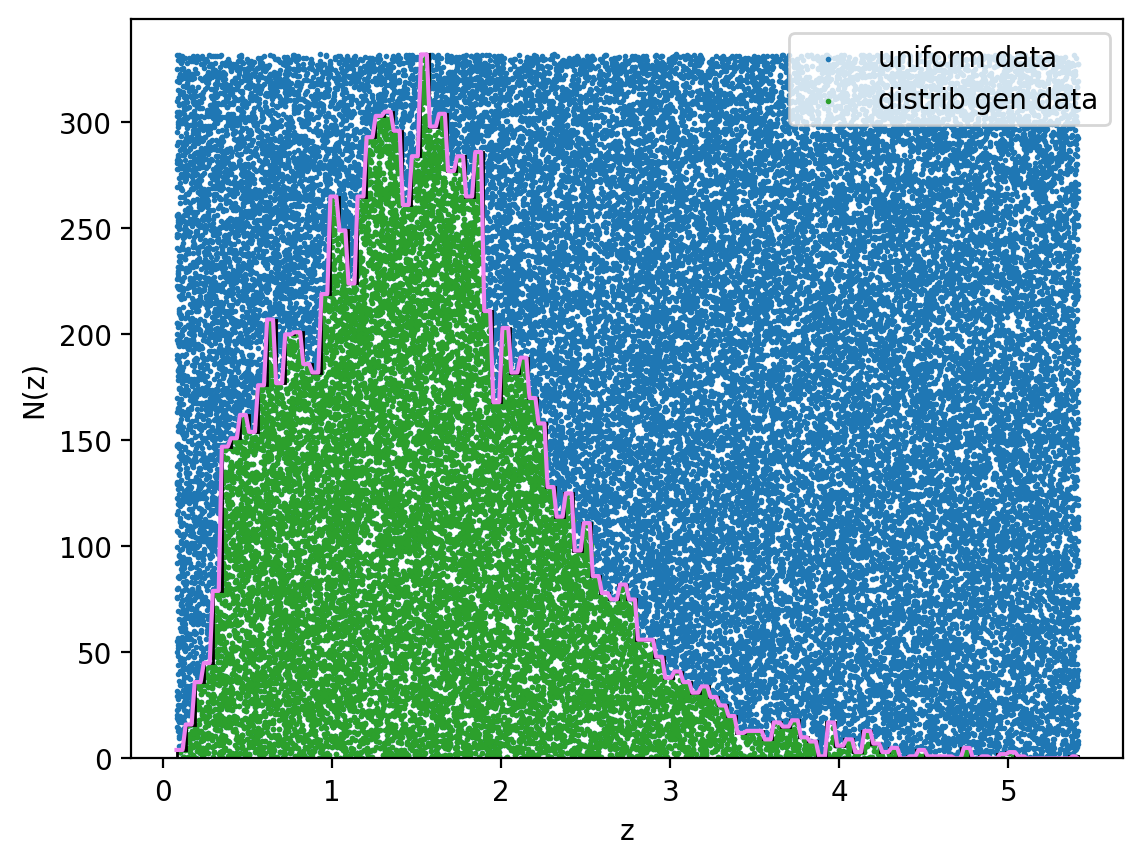

In [25]:
rejection = step_f(x_rej,bins,counts)
y_step = rejection

x_quas = x_rej[y_rej < y_step]
y_quas = y_rej[y_rej < y_step]

plt.plot(x_rej[np.argsort(x_rej)], y_step[np.argsort(x_rej)], color='violet', zorder=2)
plt.scatter(x_rej,y_rej, s=1, label='uniform data',zorder=0)
plt.hist(z,bins=100,histtype='step', color='k', zorder=1)
plt.scatter(x_quas, y_quas, s=1, label='distrib gen data',zorder=0)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.legend()
plt.show()

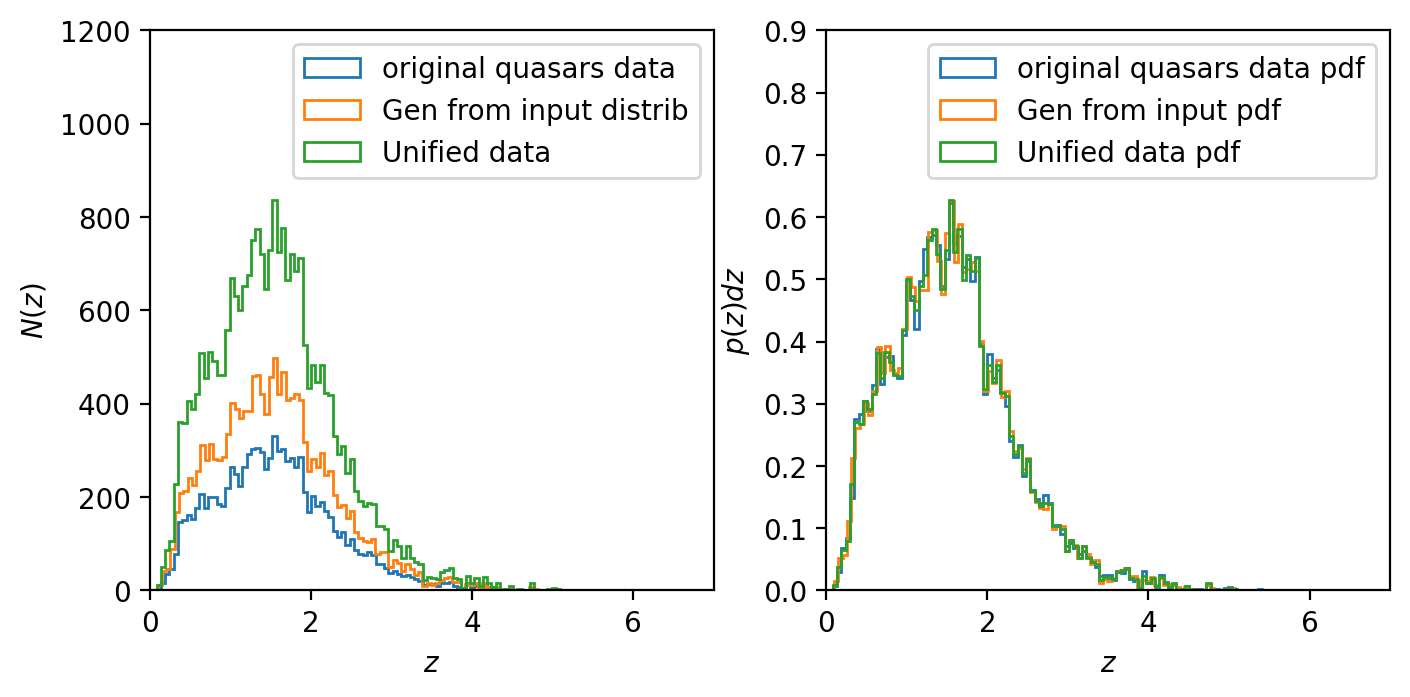

In [26]:
quasars = np.concatenate((z,x_quas))

fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)

hist(z, bins=100, histtype='step', label='original quasars data')
hist(x_quas, bins=100, histtype='step', label='Gen from input distrib')
hist(quasars, bins=100, histtype='step', label='Unified data')
ax.set_xlabel('$z$')
ax.set_ylabel('$N(z)$')
ax.set_xlim(0,7)
ax.set_ylim(0,1200)
plt.legend()

ax = fig.add_subplot(222)

hist(z, bins=100, density=True, histtype='step', label='original quasars data pdf')
hist(x_quas, bins=100, density=True, histtype='step', label='Gen from input pdf')
hist(quasars, bins=100, density=True, histtype='step', label='Unified data pdf')
ax.set_xlabel('$z$')
ax.set_ylabel('$p(z)dz$')
ax.set_xlim(0,7)
ax.set_ylim(0,0.9)
plt.legend()

plt.show()

It is possible to notice that the three pdf are pretty much the same! My pipeline is working well (but eventually I am adding some "priors" to my new resampled data, for example through the choice of the binning, of the fit used to spline the cumulative...)